In [5]:
import os
import numpy as np
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.feature import graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import os
import cv2
import shutil
import random

def preprocess_images(input_folder, output_folder, image_size=(128, 128), test_ratio=0.2):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Create train and test folders
    train_folder = os.path.join(output_folder, 'train')
    test_folder = os.path.join(output_folder, 'test')
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Iterate over subfolders
    for class_name in os.listdir(input_folder):
        class_input_folder = os.path.join(input_folder, class_name)
        class_output_folder_train = os.path.join(train_folder, class_name)
        class_output_folder_test = os.path.join(test_folder, class_name)
        os.makedirs(class_output_folder_train, exist_ok=True)
        os.makedirs(class_output_folder_test, exist_ok=True)

        # Iterate over images in the subfolder
        images = os.listdir(class_input_folder)
        random.shuffle(images)
        num_test_images = int(len(images) * test_ratio)
        test_images = images[:num_test_images]
        train_images = images[num_test_images:]

        for image_name in train_images:
            image_path = os.path.join(class_input_folder, image_name)
            output_image_path = os.path.join(class_output_folder_train, image_name)
            preprocess_and_save(image_path, output_image_path, image_size)

        for image_name in test_images:
            image_path = os.path.join(class_input_folder, image_name)
            output_image_path = os.path.join(class_output_folder_test, image_name)
            preprocess_and_save(image_path, output_image_path, image_size)

def preprocess_and_save(input_image_path, output_image_path, image_size):
    # Read and resize the image
    image = cv2.imread(input_image_path)
    if image is not None:
        image = cv2.resize(image, image_size)

        # # Convert to grayscale
        # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Save the preprocessed image
        cv2.imwrite(output_image_path, image)

# Example usage:
input_folder = r"U:\GLCM\dataset\rice leaf diseases dataset" # Path to the folder containing subfolders with images
output_folder = r"U:\GLCM\dataset\preprocessed"  # Path to the folder where preprocessed images will be saved
preprocess_images(input_folder, output_folder)


KeyboardInterrupt: 

In [1]:
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import data

def fast_glcm(img, vmin=0, vmax=255, nbit=8, kernel_size=5):
    mi, ma = vmin, vmax
    ks = kernel_size
    h,w = img.shape

    # digitize
    bins = np.linspace(mi, ma+1, nbit+1)
    gl1 = np.digitize(img, bins) - 1
    gl2 = np.append(gl1[:,1:], gl1[:,-1:], axis=1)

    # make glcm
    glcm = np.zeros((nbit, nbit, h, w), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            mask = ((gl1==i) & (gl2==j))
            glcm[i,j, mask] = 1

    kernel = np.ones((ks, ks), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            glcm[i,j] = cv2.filter2D(glcm[i,j], -1, kernel)

    glcm = glcm.astype(np.float32)
    return glcm



def fast_glcm_contrast(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm contrast
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    cont = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            cont += glcm[i,j] * (i-j)**2

    return cont


def fast_glcm_dissimilarity(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm dissimilarity
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    diss = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            diss += glcm[i,j] * np.abs(i-j)

    return diss


def fast_glcm_homogeneity(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm homogeneity
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    homo = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            homo += glcm[i,j] / (1.+(i-j)**2)

    return homo


def fast_glcm_ASM(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm asm, energy
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    asm = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            asm  += glcm[i,j]**2

    ene = np.sqrt(asm)
    return asm, ene

def fast_glcm_entropy(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm entropy
    '''
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    pnorm = glcm / np.sum(glcm, axis=(0,1)) + 1./ks**2
    ent  = np.sum(-pnorm * np.log(pnorm), axis=(0,1))
    return ent




In [2]:

def calculate_glcm_features(image):
    h, w = image.shape   
    glcm_contrast = fast_glcm_contrast(image)
    glcm_dissimilarity = fast_glcm_dissimilarity(image)
    glcm_homogeneity = fast_glcm_homogeneity(image)
    glcm_asm, glcm_energy = fast_glcm_ASM(image)
    glcm_entropy = fast_glcm_entropy(image)

    features = np.concatenate([glcm_contrast.ravel(),
                               glcm_dissimilarity.ravel(),
                               glcm_homogeneity.ravel(),
                               glcm_energy.ravel(),
                               glcm_entropy.ravel()])
    
    return features


In [3]:
def load_images_from_folder(folder):
    images = []
    labels = []
    label_mapping = {}  # Dictionary to map folder names to numeric labels
    for i, subfolder in enumerate(os.listdir(folder)):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            label_mapping[subfolder] = i  # Map folder name to numeric label
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                if img_path.endswith(".jpg") or img_path.endswith(".JPG"):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        images.append(img)
                        labels.append(i)  # Use numeric label from mapping
    print(labels)
    return images, labels


In [6]:

# Load images and labels from train and test folders
train_folder_path = r"U:\GLCM\dataset\preprocessed\train"
test_folder_path = r"U:\GLCM\dataset\preprocessed\test"
X_train, y_train = load_images_from_folder(train_folder_path)
X_test, y_test = load_images_from_folder(test_folder_path)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [7]:
# Calculate GLCM features for train and test images
X_train_features = np.array([calculate_glcm_features(image) for image in X_train])
X_test_features = np.array([calculate_glcm_features(image) for image in X_test])
# Reshape the input data to 4D tensor

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Assuming X_train_features contains GLCM features and y_train contains corresponding labels
# X_train_features and X_test_features should be in the shape (n_samples, n_features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_features, y_train, test_size=0.2, random_state=42)

# Initialize Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of trees as needed

# Train the classifier
rf.fit(X_train, y_train)

# Predict labels for test data
y_pred = rf.predict(X_test)

# Calculate probabilities for test data
y_prob = rf.predict_proba(X_test)

# Calculate confidence scores (maximum probability for each prediction)
confidence_scores = np.max(y_prob, axis=1)

# Calculate evaluation metrics for the whole model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Compute confusion matrix for the whole model
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate per-class metrics
class_precision = precision_score(y_test, y_pred, average=None)
class_recall = recall_score(y_test, y_pred, average=None)
class_f1 = f1_score(y_test, y_pred, average=None)

print("Random Forest Results (Whole Model):")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

# Print per-class metrics
print("\nPer-Class Metrics:")
for i in range(len(class_precision)):
    print(f"Class {i}: Precision={class_precision[i]}, Recall={class_recall[i]}, F1-Score={class_f1[i]}")

# Print confidence scores
print("\nConfidence Scores:")
for score in confidence_scores:
    print(score)

# Save the trained model to a file
joblib.dump(rf, 'random_forest_model_final.pkl')

Random Forest Results (Whole Model):
Accuracy: 0.9592088998763906
Precision: 0.9594553323198708
Recall: 0.9589274082280591
F1 Score: 0.9590291485273407
Confusion Matrix:
[[278   7   5]
 [  5 262   3]
 [  2  11 236]]

Per-Class Metrics:
Class 0: Precision=0.9754385964912281, Recall=0.9586206896551724, F1-Score=0.9669565217391304
Class 1: Precision=0.9357142857142857, Recall=0.9703703703703703, F1-Score=0.9527272727272728
Class 2: Precision=0.9672131147540983, Recall=0.9477911646586346, F1-Score=0.9574036511156186

Confidence Scores:
0.91
1.0
0.8
0.47
0.85
0.93
0.49
0.5
0.83
0.86
0.54
0.64
0.66
0.91
0.46
0.86
0.91
0.96
0.77
1.0
0.58
0.81
0.92
0.9
0.83
0.82
0.42
0.48
0.73
0.52
0.86
0.8
0.79
0.79
0.88
0.76
0.71
0.49
0.92
0.68
0.62
0.9
0.52
0.78
0.94
0.35
0.43
0.82
0.92
0.93
0.92
0.7
0.73
0.69
0.73
0.87
0.88
0.94
0.91
0.87
0.68
0.7
0.87
0.7
0.43
0.72
0.81
0.91
0.72
0.68
0.85
0.96
0.93
0.87
0.8
0.81
0.98
0.5
0.46
0.53
0.63
0.73
0.86
0.52
0.81
0.92
0.51
0.82
0.69
0.67
0.64
0.9
0.75
0.95
0.63


['random_forest_model_final.pkl']

In [9]:
import json

# Results dictionary
results = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "confusion_matrix": conf_matrix.tolist(),
    "per_class_metrics": {
        f"Class {i}": {
            "precision": class_precision[i],
            "recall": class_recall[i],
            "f1_score": class_f1[i]
        }
        for i in range(len(class_precision))
    },
    "confidence_scores": confidence_scores.tolist()
}

# Save results to JSON file
with open('random_forest_results.json', 'w') as f:
    json.dump(results, f)

# Save the trained model to a file
joblib.dump(rf, 'random_forest_model_final.pkl')


['random_forest_model_final.pkl']

Predicted class for the new image: 2


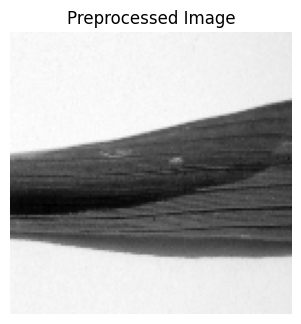

In [11]:
import numpy as np
import joblib
from PIL import Image
import cv2

# Load the saved model
loaded_model = joblib.load('random_forest_model.pkl')
new_image_path = r"C:\Users\nitro\Desktop\svm\dataset\Ricedisease\Bacterial leaf blight\DSC_0370.jpg"
new_img = np.array(Image.open(new_image_path).convert('L'))
image_size = (128, 128)
resizedimage = cv2.resize(new_img, image_size)
new_image_features = calculate_glcm_features(resizedimage)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(resizedimage, cmap='gray')
plt.title('Preprocessed Image')
plt.axis('off')
# Use the trained model to predict the class of the new image
predicted_class = loaded_model.predict([new_image_features])[0]
print("Predicted class for the new image:", predicted_class)
